## Checagem de pixels inválidos

In [1]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))
from rasterio.coords import BoundingBox

import src.data.preprocess_data as data
import src.data.view as view

import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tiles = ['032027']#, '032026'] 
num_subtiles = 6

train_files, val_files, test_files = data.train_val_test_stratify(tiles, 
                                                                  num_subtiles,
                                                                    train_size = 0.6, 
                                                                    val_size = 0.2, 
                                                                    stratify_by = 'type')

Loading:  <function yaml_filename at 0x7e753a76aef0>
File already saved, loading it.


Primeiramente, vamos carregar um dataset

In [3]:
working_dir = os.path.abspath('..')
dataset_nans = data.SubtileDataset(train_files+val_files+test_files, 
                    num_subtiles = num_subtiles, 
                    classes_mode = 'type', 
                    patch_size=256, 
                    stride=256, # sem overlap 
                    data_augmentation = False, 
                    ignore_most_nans= False,
                    return_imgidx = False,
                    treat_nans=False, # they supposelly are saved as negative, then a true here cut costs
                    debug=False)

O dataset carrega como foi salvo: Valores inválidos são negativos dos valores de interpolação.

Aqui, calculamos a quantidade ordenada de valores inválidos e obtemos o índice da ordenação por quantidade deles. 


In [4]:

most_nan_img = None
most_nan_mask = None
num_nan = 0

indices = []
num_nans = []
for i, (img, mask) in enumerate(dataset_nans):
    negatives = torch.sum(img < 0).item()
    urban = torch.sum(mask > 0).item()
    indices.append(i)
    num_nans.append(negatives)

ordered_idx = np.argsort(num_nans)
len(ordered_idx)

1764

### Histograma

[384, 1464, 96, 0, 396, 936, 6636, 3528, 0, 192, 288, 264, 96, 0, 252, 708, 228, 0, 1848, 372, 192, 96, 96, 48, 3768, 708, 48, 0, 372, 408, 0, 384, 0, 0, 0, 144, 0, 0, 0, 96, 432, 144, 492, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1404, 0, 48, 0, 240, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 48, 240, 0, 0, 0, 0, 0, 0, 324, 48, 0, 0, 0, 0, 336, 0, 0, 0, 0, 1320, 1704, 1056, 5544, 22440, 43056, 1392, 5508, 7296, 2064, 15672, 6912, 5148, 1428, 10476, 6024, 1836, 19704, 5640, 8652, 1992, 2508, 1272, 3084, 22980, 9324, 8280, 240, 0, 0, 1680, 156, 1584, 144, 36, 120, 0, 1872, 0, 144, 0, 0, 48, 288, 1404, 0, 0, 0, 0, 144, 0, 0, 48, 0, 0, 0, 480, 288, 192, 0, 192, 0, 0, 96, 96, 0, 0, 0, 96, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 288, 0, 0, 96, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 96, 18612, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 0

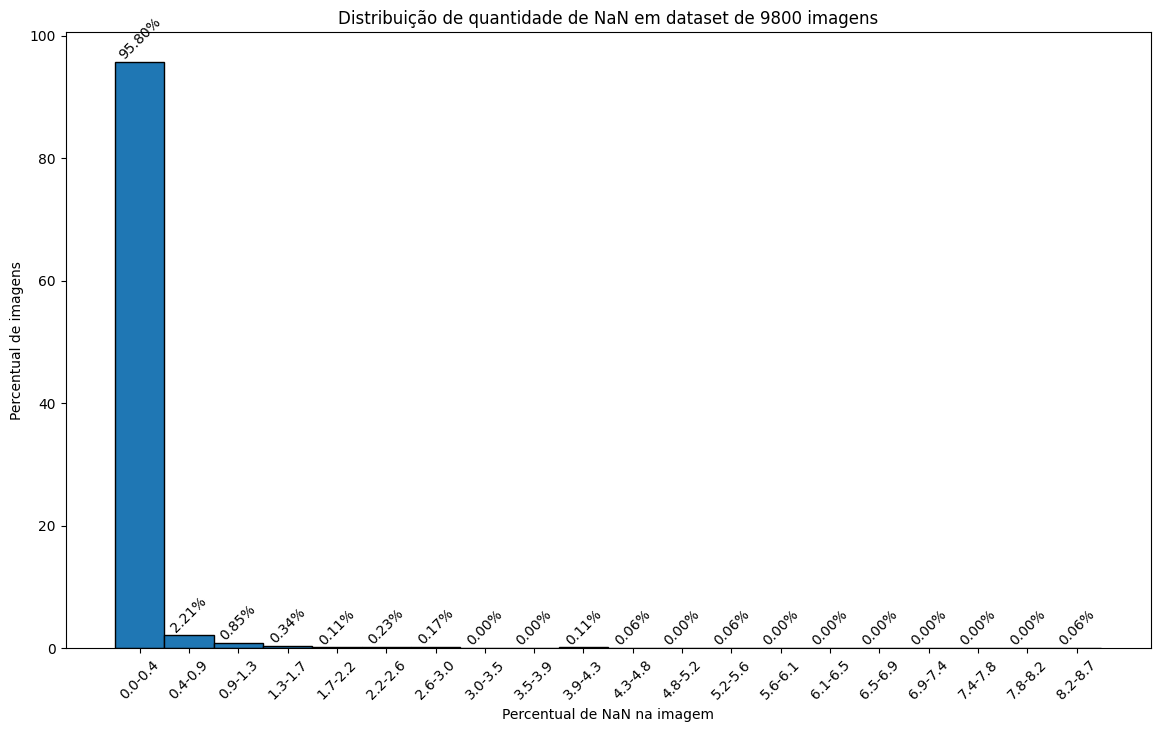

In [5]:

print(num_nans)
print(indices)
print([indices[i] for i in ordered_idx])
print([num_nans[i] for i in ordered_idx])
print([num_nans[i]/img.numel() for i in ordered_idx])

data = [num_nans[i]/img.numel()*100 for i in ordered_idx]
plt.figure(figsize=(14, 8))
counts, bins, patches = plt.hist(data, bins=20, edgecolor='black', weights=[100/len(data)]*len(data))  # Histogram
sample_counts, _ = np.histogram(data, bins=20)
cumulative_sum = [sum(sample_counts[:i+1]) for i in range(len(sample_counts))]
print(cumulative_sum)
# Calculate midpoints for labels
midpoints = 0.5 * (bins[1:] + bins[:-1])  # Midpoints for 20 bins
bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]

for i in range(len(counts)):
    print(f"Bin {i+1}: Range [{bins[i]:.2f}, {bins[i+1]:.2f}) contains {counts[i]} points")

for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, f'{count:.2f}%', ha='center', va='bottom', rotation=45)  # Centered above each bar
# Apply labels to midpoints
plt.xticks(midpoints, bin_labels, rotation=45)  # Use midpoints instead of bin edges

plt.xlabel('Percentual de NaN na imagem')
plt.ylabel('Percentual de imagens')
plt.title('Distribuição de quantidade de NaN em dataset de 9800 imagens')
#plt.yscale('log')  # Use log scale to better visualize large ranges

save_to = os.path.join(working_dir, 'figs', 'nans_distribution.png')
plt.savefig(save_to, bbox_inches='tight', pad_inches=0)
plt.show()

Escolhemos as imagens com mais valores inválidos entro dos bins 1, 10 e 20 para mostrar.

In [6]:

num_nans.sort
most_nan_img = img.clone() 
num_nan = negatives
most_nan_mask = mask.clone()

chosen_bins = [0,9,19] #bins 1, 10 e 20
idxs_ =[cumulative_sum[i]-1 for i in chosen_bins]

choices = [indices[i] for i in [ordered_idx[j] for j in idxs_]]

print(choices)
print([num_nans[i] for i in choices])
imgs = []
masks = []
for c in choices:
    img,mask = dataset_nans[c]
    imgs.append(img)
    masks.append(mask)



[909, 1537, 1193]
[3312, 32760, 68148]


### Plot das imagens
Adicionando pixel vermelhor nos valores inválidos.

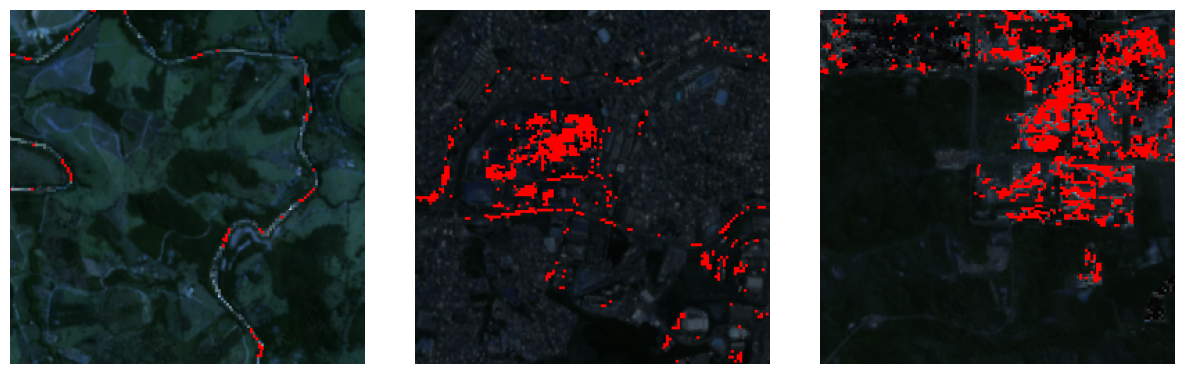

In [7]:
import numpy as np
nan_value = most_nan_img.max()

plt.figure(figsize=(12,16))
imgs_with_nan = []
nan_count = [0,0,0]
for idx in range(3):
    plt.subplot(1,3,idx+1)
    img_ = imgs[idx]
    mask_ = masks[idx]
    r = img_[1,:,:].squeeze()
    g = img_[2,:,:].squeeze()
    b = img_[3,:,:].squeeze()
    rgb_image = torch.stack([r, g, b], axis=-1)
    min = rgb_image[rgb_image > 0].min().item()
    rgb_image = rgb_image-min
    rgb_image*=1/(rgb_image.max())
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            if r[i,j]<0:
                nan_count[idx]+=1
                rgb_image[i,j,0] = 1
                rgb_image[i,j,1] = 0
                rgb_image[i,j,2] = 0
    #rgb_image = rgb_image-rgb_image.min()
    #rgb_image*=1/(rgb_image.max())
    imgs_with_nan.append(rgb_image)
    plt.imshow(rgb_image)
    #plt.imshow(mask_.squeeze(), alpha=0.1)
    plt.tight_layout()
    plt.axis('off')
    

save_to = os.path.join(working_dir, 'figs', 'invalid_pixels.png')
plt.savefig(save_to, bbox_inches='tight', pad_inches=0)
plt.show()

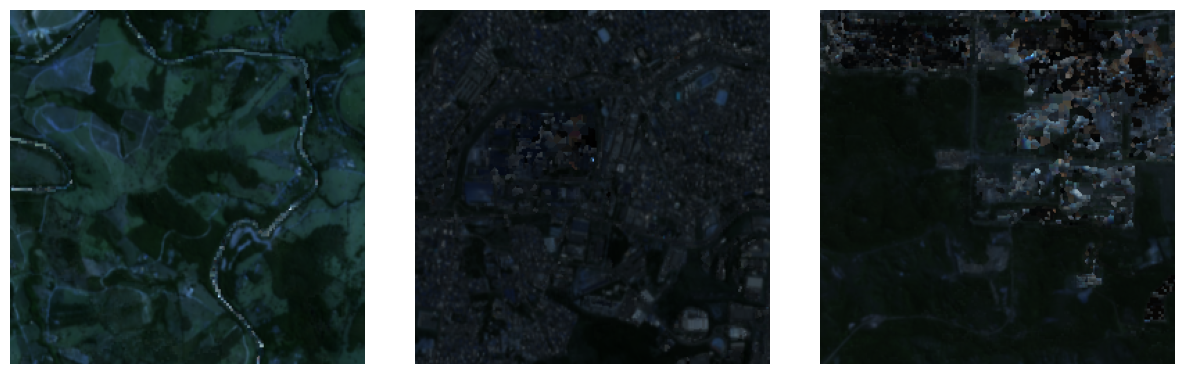

In [8]:
import numpy as np
nan_value = most_nan_img.max()
imgs_nearest = []
plt.figure(figsize=(12,16))

for idx in range(3):
    plt.subplot(1,3,idx+1)
    img_ = torch.abs(imgs[idx])
    mask_ = masks[idx]
    r = img_[1,:,:].squeeze()
    g = img_[2,:,:].squeeze()
    b = img_[3,:,:].squeeze()
    rgb_image = torch.stack([r, g, b], axis=-1)
    min = rgb_image[rgb_image > 0].min().item()
    rgb_image = rgb_image-min
    rgb_image*=1/(rgb_image.max())
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            if r[i,j]<0:
                rgb_image[i,j,0] = 1
                rgb_image[i,j,1] = 0
                rgb_image[i,j,2] = 0
    #rgb_image = rgb_image-rgb_image.min()
    #rgb_image*=1/(rgb_image.max())
    imgs_nearest.append(rgb_image)
    plt.imshow(rgb_image)
    #plt.imshow(mask_.squeeze(), alpha=0.1)
    plt.tight_layout()
    plt.axis('off')
    
save_to = os.path.join(working_dir, 'figs', 'nearest_pixels.png')
plt.savefig(save_to, bbox_inches='tight', pad_inches=0)

plt.show()

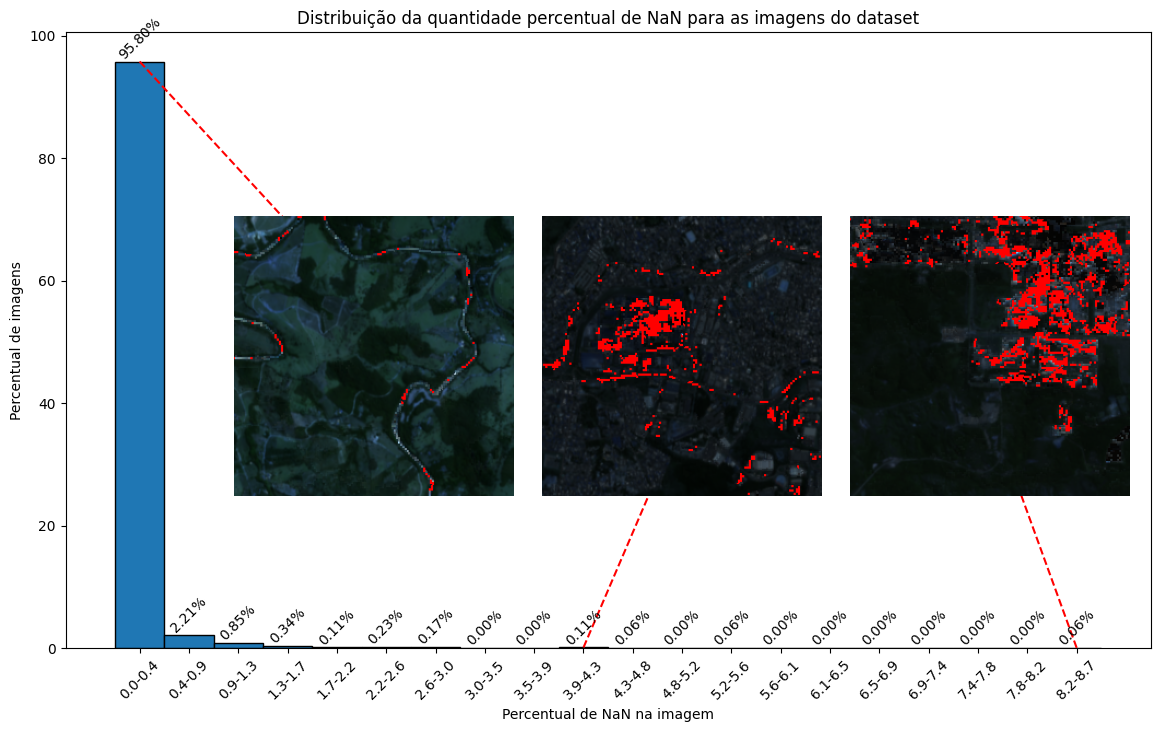

[276, 2730, 5679]


In [9]:
fig, ax = plt.subplots(figsize=(14, 8))
counts, bins, patches = ax.hist(data, bins=20, edgecolor='black', weights=[100/len(data)]*len(data))  # Histogram

for count, bin_edge in zip(counts, bins[:-1]):
    ax.text(bin_edge + (bins[1] - bins[0]) / 2, count, f'{count:.2f}%', ha='center', va='bottom', rotation=45)  # Centered above each bar
# Apply labels to midpoints
plt.xticks(midpoints, bin_labels, rotation=45)  # Use midpoints instead of bin edges

plt.xlabel('Percentual de NaN na imagem')
plt.ylabel('Percentual de imagens')
plt.title('Distribuição da quantidade percentual de NaN para as imagens do dataset')
#plt.yscale('log')  # Use log scale to better visualize large ranges

positions = [
    (0.17, 0.3),  # Top-left
    (0.39, 0.3),  # Top-center
    (0.61, 0.3),  # Top-right
]

# Step 5: Overlay the images at specified positions
for i, pos in enumerate(positions):
    image = imgs_with_nan[i]
    
    # Create a new axes for the image at the specified position
    image_ax = fig.add_axes([pos[0], pos[1], 0.35, 0.35])  # [x, y, width, height] in figure coordinates
    image_ax.imshow(image)
    image_ax.axis('off')  # Turn off axes for the image

bin_indices = [0, 9, 19]  # Indices of the bins to connect to
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in bin_indices]  # Get the center of the selected bins
bin_heights = [counts[i] for i in bin_indices]  # Get the height (frequency) of the selected bins

linepos = [
    (0.2, 0.7), 
    (0.55, 0.3), 
    (0.87, 0.3), 
]
for i, (pos, bin_center, bin_height) in enumerate(zip(linepos, bin_centers, bin_heights)):
    # Convert image position from axes fraction to data coordinates
    image_x, image_y = ax.transAxes.transform(pos)  # Transform to display coordinates
    image_x, image_y = ax.transData.inverted().transform((image_x, image_y))  # Transform to data coordinates
    
    # Draw a line from the image to the bin
    ax.plot([bin_center, image_x], [bin_height, image_y], color='red', linestyle='--', linewidth=1.5)



save_to = os.path.join(working_dir, 'figs', 'nans_distribution.png')
plt.savefig(save_to, bbox_inches='tight', pad_inches=0)
plt.show()
print(nan_count)